# Moore-Penrose pseudo inverse


In [140]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt


Write a function computing the Moore-Penrose pseudo inverse, exploiting the full SVD.

$$A^\dagger = V \Sigma^{-1} U^T, \quad A = U \Sigma V^T$$


In [141]:
def my_pinv_fullSVD(A):
    # SOLUTION-BEGIN
    U, s, VT = np.linalg.svd(A)
    s[s > 0] = 1 / s[s > 0]
    Pinv = VT.transpose() @ la.diagsvd(s, A.shape[1], A.shape[0]) @ U.transpose()
    # SOLUTION-END
    return Pinv

Write now a function computing the Moore-Penrose pseudo inverse, exploiting the reduced SVD.


In [142]:
def my_pinv_thinSVD(A):
    # SOLUTION-BEGIN
    U, s, VT = np.linalg.svd(A, full_matrices=False)
    s[s > 0] = 1 / s[s > 0]
    Pinv =  (VT.transpose() * s) @ U.transpose()
    # SOLUTION-END
    return Pinv

Generate a random matrix $A$ (with elements sampled from a standard Gaussian distribution) with 5 rows and 4 columns. Compute its Moore-Penrose pseudo inverse thorugh the two functions above defined, and compare the result with the function `numpy.linalg.pinv` (see [Documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html)).


In [143]:
A = np.random.randn(5, 4)
Apinv_numpy = np.linalg.pinv(A)
Apinv_fullSVD = my_pinv_fullSVD(A)
Apinv_thinSVD = my_pinv_thinSVD(A)
print(np.linalg.norm(Apinv_numpy - Apinv_fullSVD) / np.linalg.norm(Apinv_numpy))
print(np.linalg.norm(Apinv_numpy - Apinv_thinSVD) / np.linalg.norm(Apinv_numpy))

9.332652189948006e-17
9.332652189948006e-17


Compare the three implementations performances through the Google Colab magic command `%timeit`.


In [144]:
%timeit np.linalg.pinv(A)

13.4 µs ± 199 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [145]:
%timeit my_pinv_fullSVD(A)

13.4 µs ± 274 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [146]:
%timeit my_pinv_thinSVD(A)

10.5 µs ± 259 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# Least-square regression


Consider the linear model

$$
y = mx + q.
$$

where $m = 2$ and $q = 3$.

Generate $N = 100$ points $x_i$, sampling from a standard Gaussian distribution, and the associated $y_i$. Then, add a synthetic noise ($\epsilon_i$) by sampling from a Gaussian distribution with zero mean and standard deviation $\sigma = 2$. Plot the noisy data $(x_i, \tilde{y}_i)$, where $\tilde{y}_i = y_i + \epsilon_i$, in the $(x,y)$ plane, together with the line $y = mx + q$.


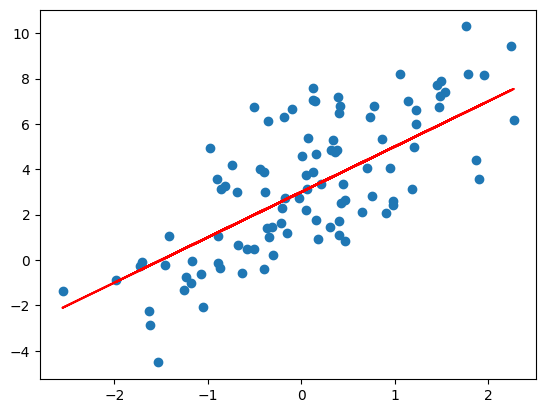

In [147]:
m = 2.0
q = 3.0
N = 100
noise = 2.0

np.random.seed(0)

# SOLUTION-BEGIN
X = np.random.randn(N)
Y = m * X + q + noise * np.random.randn(N)
plt.scatter(X, Y)
plt.plot(X, m * X + q, color="red")
# SOLUTION-END

Using the previously implemented functions to compute the Moore-Penrose pseudo inverse, solve the least-squares problem

$$
\min_{m,q} \sum_{i=1}^N (\tilde{y}_i - (m x_i + q))^2
$$

and display the regression line superimposed to the noisy data and the exact model. Define

$$\Phi = [\mathbf{x}, \mathbf{1}] \in \mathbb R^{N \times 2}$$

The least square problem is

$$\Phi \mathbf{w} = \mathbf{y}$$

With solution

$$\mathbf{w} = \Phi^\dagger \mathbf{y}$$

where

$$\mathbf{w} = [\hat m, \hat q]$$

Notice that in general

$$\mathbf{y}^{Test} = \Phi^{Test} \mathbf{w}$$

that in our case is equivalent to 

$$\mathbf{y}_i^{Test} = \hat{m} \mathbf{x}_i^{Test} + \hat{q}$$




In [148]:
# SOLUTION-BEGIN
Phi = np.column_stack([X[:, np.newaxis], np.ones((N, 1))])
z = my_pinv_thinSVD(Phi) @ Y
m_hat = z[0]
q_hat = z[1]
print(f"m_hat = {m_hat:.3f}")
print(f"q_hat = {q_hat:.3f}")
# SOLUTION-END

m_hat = 2.229
q_hat = 3.150


Plot a scatter of the data points, the "real" linear model and the estimated linear model with SVD

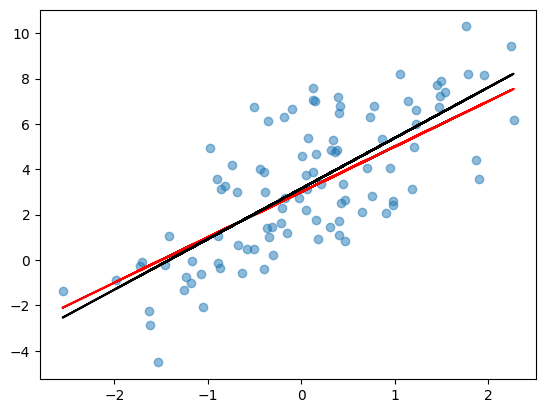

In [149]:
# SOLUTION-BEGIN
plt.scatter(X, Y, alpha=0.5)
plt.plot(X, m * X + q, color="red")
plt.plot(X, m_hat * X + q_hat, color="k")
# SOLUTION-END

Repeat the excercise by solving the normal equations with `np.solve`. 
$$(\Phi^T \Phi)^{-1} \mathbf{w} = \Phi^T \mathbf{y}$$
Compare the results.


In [150]:
# SOLUTION-BEGIN
z2 = np.linalg.solve(Phi.transpose() @ Phi, Phi.transpose() @ Y)
np.linalg.norm(z - z2)
# SOLUTION-END

9.930136612989092e-16

# Ridge regression and Kernel regression


Consider the function

$$
y = f(x) = \tanh(2x - 1).
$$

Generate $N = 100$ points $x_i$, sampling from a standard Gaussian distribution, and the associated $y_i$. Then, add a synthetic noise ($\epsilon_i$) by sampling from a Gaussian distribution with zero mean and standard deviation $\sigma = 0.1$. Plot the noisy data $(x_i, \tilde{y}_i)$, where $\tilde{y}_i = y_i + \epsilon_i$, in the $(x,y)$ plane.

Then, generate 1000 testing points, uniformly distributed in the interval $[-3,3]$, and display the function $y = f(x)$ in correspondence of the testing points.


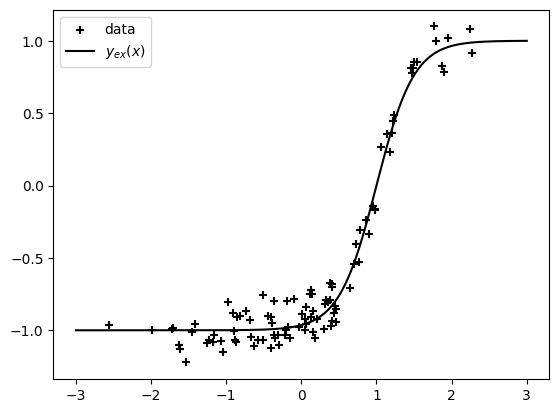

In [151]:
np.random.seed(0)

# SOLUTION-BEGIN
N = 100
noise = 0.1
y_ex = lambda x: np.tanh(2 * (x - 1))

X = np.random.randn(N, 1)
Y = y_ex(X) + noise * np.random.randn(N, 1)

N_test = 1000
X_test = np.linspace(-3, 3, N_test).reshape((-1, 1))
Y_test_ex = y_ex(X_test)

plt.scatter(X, Y, marker="+", color="black", label="data")
plt.plot(X_test, Y_test_ex, color="black", label="$y_{ex}(x)$")
plt.legend()
# SOLUTION-END

Proceeding as in the previous exercise, compute the regression line resulting from the **least squares regression** of data $(x_i, \tilde{y}_i)$. Plot the resulting regression line.


m_hat = 0.540
q_hat = -0.619


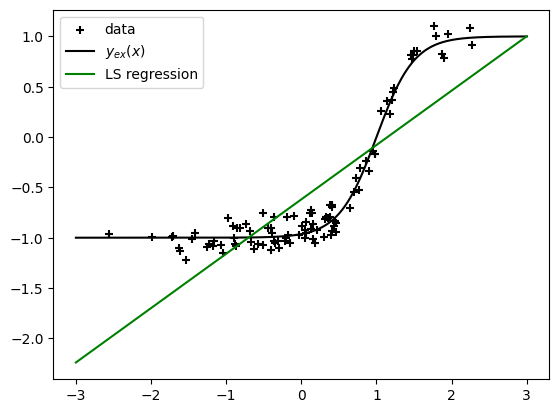

In [152]:
# SOLUTION-BEGIN
Phi = np.block([X, np.ones((N, 1))])
z = my_pinv_thinSVD(Phi) @ Y
m_hat = z[0, 0]
q_hat = z[1, 0]
print(f"m_hat = {m_hat:.3f}")
print(f"q_hat = {q_hat:.3f}")
Y_test_LS = m_hat * X_test + q_hat

plt.scatter(X, Y, marker="+", color="black", label="data")
plt.plot(X_test, Y_test_ex, color="black", label="$y_{ex}(x)$")
plt.plot(X_test, Y_test_LS, color="green", label="LS regression")
plt.legend()
# SOLUTION-END

Let us now consider **ridge regression**, corresponding to a regularizaton parameter $\lambda = 1.0$.
Solve the equations in two ways:
1. Using the normal equations
$$[(\Phi^T \Phi) + \lambda I] \mathbf{w} = \Phi^T \mathbf{y}$$
2. Using the Woodbury idenitity to write the normal equations in "kernel-form"
$$\mathbf{w} = \Phi^T \boldsymbol{\alpha}, \quad [(\Phi \Phi^T) + \lambda I] \boldsymbol{\alpha} = \mathbf{y}$$

Check that the two approaches lead to the same result.
Compare the obtained regression line with the one obtained through least squares regression when changing $\lambda$.


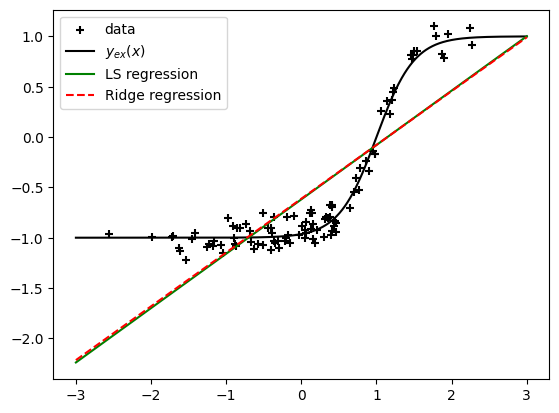

In [153]:
# SOLUTION-BEGIN
lam = 1.0
PhiPhiT = Phi @ Phi.transpose()
alpha = np.linalg.solve(PhiPhiT + lam * np.eye(N), Y)
w = Phi.transpose() @ alpha
w2 = np.linalg.solve(Phi.T @ Phi + lam * np.eye(2), Phi.T @ Y)
Phi_test = np.block([X_test, np.ones((N_test, 1))])
Y_test_RR = Phi_test @ w

plt.scatter(X, Y, marker="+", color="black", label="data")
plt.plot(X_test, Y_test_ex, color="black", label="$y_{ex}(x)$")
plt.plot(X_test, Y_test_LS, color="green", label="LS regression")
plt.plot(X_test, Y_test_RR, color="red", linestyle="--", label="Ridge regression")
plt.legend()
# SOLUTION-END

Consider now **kernel regression**.

$$(K + \lambda I) \boldsymbol{\alpha} = \mathbf{y}$$

Where $K_{ij} = \mathcal{K}(x_i, x_j)$ and we consider

1. The scalar product kernel
   $$\mathcal{K}(x_i, x_j) = x_i x_j + 1.$$

2. The higher-order scalar product kernel, for $q > 1$.
   $$\mathcal{K}(x_i, x_j) = (x_i x_j + 1)^q.$$

3. The Gaussian kernel, for $\sigma > 0$.
   $$\mathcal{K}(x_i, x_j) = \exp\left(-\frac{(x_i - x_j)^2}{2 \sigma^2}\right).$$


The evaluation on the test data-point $\hat{x}$ is computed as 

$$\hat{\mathbf{y}} = \sum_{i = 1}^N \alpha_i \mathcal{K}(\hat{x}, x_i) = K^{Test} \boldsymbol{\alpha}$$


/tmp/ipykernel_2285756/1513242630.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i, j] = kernel(X[i], X[j])
/tmp/ipykernel_2285756/1513242630.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K_test[i, j] = kernel(X_test[i], X[j])


(-2.0, 2.0)

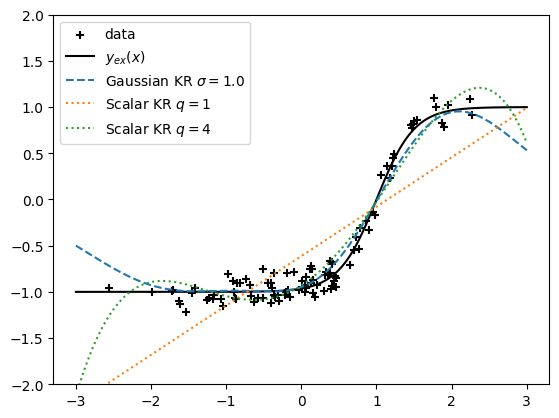

In [154]:
# SOLUTION-BEGIN
lam = 1.0
q = 4
sigma = 1.0


def product_kernel(x1, x2):
    return x1 * x2 + 1


def high_order_kernel(x1, x2):
    return (x1 * x2 + 1) ** q


def gaussian_kernel(x1, x2):
    return np.exp(-(((x1 - x2) / sigma) ** 2) / 2)


def kernel_regression(kernel):
    N = X.shape[0]
    K = np.empty((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = kernel(X[i], X[j])
    alpha = np.linalg.solve(K + lam * np.eye(N), Y)
    K_test = np.empty((X_test.shape[0], N))
    for i in range(K_test.shape[0]):
        for j in range(K_test.shape[1]):
            K_test[i, j] = kernel(X_test[i], X[j])
    Y_test_KR = K_test @ alpha
    return Y_test_KR


plt.scatter(X, Y, marker="+", color="black", label="data")
plt.plot(X_test, Y_test_ex, color="black", label="$y_{ex}(x)$")
plt.plot(
    X_test,
    kernel_regression(gaussian_kernel),
    linestyle="--",
    label=f"Gaussian KR $\sigma = {sigma}$",
)
plt.plot(
    X_test,
    kernel_regression(product_kernel),
    linestyle=":",
    label=f"Scalar KR $q = 1$",
)
plt.plot(
    X_test,
    kernel_regression(high_order_kernel),
    linestyle=":",
    label=f"Scalar KR $q = {q}$",
)
plt.legend()
plt.ylim([-2, 2])
# SOLUTION-END

As an advance homework, try to write the matrix $K$ without using a for loop.
Hint: you have to rewrite the kernel function $\mathcal{K}$ to work with matrices.

(-2.0, 2.0)

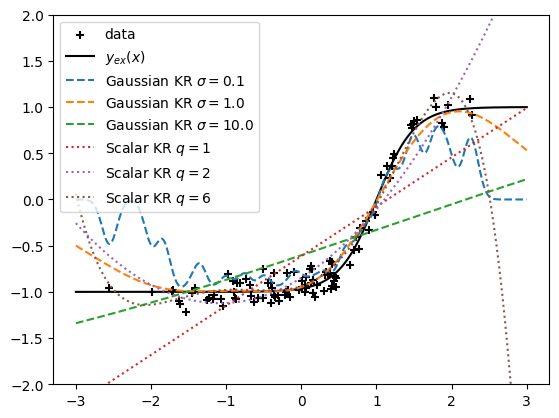

In [155]:
# SOLUTION-BEGIN
lam = 1.0

def scalar_product_kernel_q(q):
    def kernel(X1, X2):
        return (X1 @ X2.T + 1) ** q

    return kernel


def gaussian_kernel_sigma(sigma):
    def kernel(X1, X2):
        X1_sq = np.sum(X1**2, axis=1)[:, None]
        X2_sq = np.sum(X2**2, axis=1)[None, :]
        sq_dists = X1_sq + X2_sq - 2 * X1 @ X2.T
        return np.exp(-sq_dists / (2 * sigma**2))

    return kernel


def kernel_regression(kernel):
    K = kernel(X, X)
    N = X.shape[0]
    alpha = np.linalg.solve(K + lam * np.eye(N), Y)
    K_test = kernel(X_test, X)
    Y_test_KR = K_test @ alpha
    return Y_test_KR


plt.scatter(X, Y, marker="+", color="black", label="data")
plt.plot(X_test, Y_test_ex, color="black", label="$y_{ex}(x)$")
for sigma in [0.1, 1.0, 10.0]:
    plt.plot(
        X_test,
        kernel_regression(gaussian_kernel_sigma(sigma)),
        linestyle="--",
        label=f"Gaussian KR $\sigma = {sigma}$",
    )
for q in [1, 2, 6]:
    plt.plot(
        X_test,
        kernel_regression(scalar_product_kernel_q(q)),
        linestyle=":",
        label=f"Scalar KR $q = {q}$",
    )
plt.legend()
plt.ylim([-2, 2])
# SOLUTION-END